# (Ivan) Blog Post

## Introduction

In this section, we discuss:
- A few extra EDA studies related to finding trivial methods of classifying the analysed time series
- The usage of LSTM and DLM models for predicting time series

### Initial Steps

Before all else, we import the necessary packages:

In [2]:
# 'numpy' for array manipulation
import numpy as np

# 'matplotlib.pyplot' and 'seaborn' for graph plotting
import matplotlib.pyplot as plt
import seaborn as sns

# 'scipy.stats' for statistical functions
import scipy.stats

# 'pandas' for tabular data set manipulation
import pandas as pd

# 'datetime' for using 'datetime' data types
import datetime

# 'keras.models' and 'keras.layers' for LSTM model
import keras.models
import keras.layers

# 'sklearn.preprocessing' for additional statistical functions
import sklearn.preprocessing

# 'custompack' for using functions made specifically
# for the competition
import custompack

Using Theano backend.


Next, import the necessary data sets:

In [3]:
# Load the necessary tabular data sets

# Prerequisites:
# - 'train.csv' // .csv
# - 'oil.csv' // .csv
# - 'test.csv' // .csv

# 'dataframe_train' is training data set
dataframe_train = pd.read_csv(
    filepath_or_buffer = 'Data_1st_prj/train.csv',
)

# 'dataframe_oil' is oil price data set
dataframe_oil = pd.read_csv(
    filepath_or_buffer = 'Data_1st_prj/oil.csv',
)

# 'dataframe_test' is test data set (projected 'onpromotion' figures)
dataframe_test = pd.read_csv(
    filepath_or_buffer = 'Data_1st_prj/test.csv',
)

# 'dataframe_transactions' is transactions data set
dataframe_transactions = pd.read_csv(
    filepath_or_buffer = 'Data_1st_prj/transactions.csv'
    )


Here, we quickly check for the presence of missing values in our data sets.

'oil.csv' is the only data set to have missing values which we deal with later.

The 'null_detection' function is a custom function from 'custompack'.

In [4]:
# Check for presence of missing values in dataframes
(
    custompack.null_detection(
        dataframe = dataframe_train
        ),
    custompack.null_detection(
        dataframe = dataframe_transactions
        ),
    custompack.null_detection(
        dataframe = dataframe_oil
        ),
    custompack.null_detection(
        dataframe = dataframe_test
        )
)
# The presence of a 'True' boolean in the tuple
# indicates missing values for the corresponding
# data set

# 'dataframe_oil' has missing values


(False, False, True, False)

Both the 'train.csv' and 'test.csv' data sets are combined to create a full set of date and promotion time series. The series can be shortened later when needed.

In [5]:
# Prerequisites:
# - 'dataframe_train' // dataframe
# - 'dataframe_test' // dataframe

# Join both the 'dataframe_train' and the 'dataframe_test' data sets
# for future use
dataframe_full = pd.concat(
    objs = [
        dataframe_train,
        dataframe_test,
    ],
    sort = True,
)

# Drop redundant 'id' feature from 'dataframe_full'
dataframe_full = dataframe_full.drop(
    labels = [
        'id',
    ],
    axis = 1,
)


Since the 'date' feature of the 'train.csv' and 'test.csv' data sets excludes some dates (Christmas days), we merge a complete set of dates, 'dataframe_fulldate', with the 'dataframe_full' so all dates are considered.

In [6]:
# Create full series of dates from
# 2013-01-01 to 2017-08-31

# Prerequisites:
# - None

# Create 'datetime_start_date' as the starting date
datetime_start_date = datetime.datetime(
    year = 2013,
    month = 1,
    day = 1,
)

# Create 'datetime_end_date' as the final date
datetime_end_date = datetime.datetime(
    year = 2017,
    month = 8,
    day = 31,
)

# Create 'datetimeindex_fulldate', the list of all
# dates from the initial to the final date
datetimeindex_fulldate = pd.date_range(
    start = datetime_start_date,
    end = datetime_end_date,
)

# Convert 'datetimeindex_fulldate' into a pandas
# dataframe
dataframe_fulldate = pd.DataFrame(
    data = {
        'date': datetimeindex_fulldate,
    },
)


The 'time_series_retrieval' function defined below provides quick access to a usable 'sales' and 'onpromotion' time series. The missing values were replaced with zeros since, presumably, there were no sales during Christmas days and any sales figure after '2017-08-15' would be predicted anyway.

The 'index_reset' function is a custom function from 'custompack'.

In [7]:
# Define the 'time_series_retrieval' function

# Prerequisites:
# - 'dataframe_full' // dataframe
# - 'index_reset' // function
# - 'dataframe_fulldate' // dataframe

def time_series_retrieval(
    store_number,
    family,
):
    
    '''
    The 'time_series_retrieval' function retrieves
    the sales and promotion time series for a given
    store number and product family.
    '''

    # Filter 'dataframe_full' by the input store
    # number and family to get 'dataframe_x_1'
    dataframe_x_1 = dataframe_full[
        (
            dataframe_full[
                'store_nbr' # No comma here
            ] == store_number
        ) & (
            dataframe_full[
                'family' # No comma here
            ] == family
        )
    ]
    
    # Reset the index of 'dataframe_x_1' to
    # get 'dataframe_x_2'
    dataframe_x_2 = custompack.index_reset(
        dataframe = dataframe_x_1,
        )

    # Drop the 'store_nbr' and 'family' features
    # from 'dataframe_x_2' to get 'datafarme_x_3'
    dataframe_x_3 = dataframe_x_2.drop(
        labels = [
            'store_nbr',
            'family',
        ],
        axis = 1,
    )

    # Convert the 'date' feature in 'dataframe_x_3'
    # to be of a 'datetime' data type
    dataframe_x_3['date'] = pd.to_datetime(
        arg = dataframe_x_3[
            'date' # No comma here
        ],
    )
    
    # Merge 'dataframe_fulldate' with the 'date' feature of
    # 'dataframe_x_3' to get 'dataframe_x_4'
    dataframe_x_4 = dataframe_x_3.merge(
        right = dataframe_fulldate,
        how = 'right',
        on = 'date',
    )
    
    # Sort the observations in 'dataframe_x_4' 
    # by increasing 'date' to get 'dataframe_x_5'
    dataframe_x_5 = dataframe_x_4.sort_values(
        by = 'date', 
        ascending = True,
    )

    # Fill missing values of 'dataframe_x_5' with 
    # zeros to get 'dataframe_x_6'
    dataframe_x_6 = dataframe_x_5.fillna(
        value = 0,
    )

    # Reset the index of 'dataframe_x_6' to get
    # 'dataframe_x_f'
    dataframe_x_f = custompack.index_reset(
        dataframe = dataframe_x_6,
    )

    return(
        dataframe_x_f # No comma here to avoid tuples
    )


Here, we prepare 'dataframe_oil' into a time series that will be joined to 'dataframe_full'.

In [8]:
# Here, we modify the oil data set to include
# all dates and replace all missing values
# with front fills

# Prerequisites:
# - 'dataframe_oil' // dataframe
# - 'dataframe_fulldate' // dataframe

# Change the 'date' feature in 'dataframe_oil' 
# to be in 'datetime' form
dataframe_oil['date'] = pd.to_datetime(
    arg = dataframe_oil[
        'date' # No comma here
    ],
)

# Join the 'dataframe_fulldate' dataframe with
# 'dataframe_oil' to get 'dataframe_oil_mod_1',
# which contains all required dates
dataframe_oil_mod_1 = pd.merge(
    left = dataframe_oil,
    right = dataframe_fulldate,
    how = 'right',
    on = 'date',
)

# Sort all observations in 'dataframe_oil_mod_1'
# by 'date' to get 'datarame_oil_mod_2'
dataframe_oil_mod_2 = dataframe_oil_mod_1.sort_values(
    by = 'date',
)

# Reset the index of 'dataframe_oil_mod_2' to get
# 'dataframe_oil_mod_3'
dataframe_oil_mod_3 = custompack.index_reset(
    dataframe = dataframe_oil_mod_2,
)

# Front fill all missing values in 'dataframe_oil_mod_3'
# to get 'dataframe_oil_mod_4'
dataframe_oil_mod_4 = dataframe_oil_mod_3.ffill()

# Finally, backfill any remaining missiing values of
# 'dataframe_oil_mod_4' to get 'dataframe_oil_mod_f'
dataframe_oil_mod_f = dataframe_oil_mod_4.bfill()

The 'short_sales_series' function retrieves only the sales time series shortened by 16 days for a given store number and product family.

The 'series_extender' function is a custom function from 'custompack'.

In [9]:
def short_sales_series(
    store_number,
    family
    ):

    dataframe_series = time_series_retrieval(
        store_number = store_number,
        family = family
    )

    series_sales = dataframe_series[
        'sales'
    ]

    series_sales_short = custompack.series_extender(
        series_main = series_sales,
        int_extension = - 16
    )

    return(
        series_sales_short
    )

Finally, we create 'dataframe_subject_f', the dataframe containing all the time series we may need for predicting the sales figures for a chosen product family and a chosen store number.

In [10]:
# Prerequisites:
# - 'dataframe_oil_mod_f' // dataframe
# - 'time_series_retrieval' // function

# Use 'time_series_retrieval' function to prepare
# sales and promotion time series to be used in
# 'dataframe_subject_1'
dataframe_subject_1 = time_series_retrieval(
    store_number = 20,
    family = 'EGGS'
)

# Join 'dataframe_oil_mod_f' with 'dataframe_subject_1'
# to collect all three time series into one complete
# dataframe 'dataframe_subject_f'
dataframe_subject_f = pd.merge(
    left = dataframe_subject_1,
    right = dataframe_oil_mod_f,
    how = 'outer',
    on = 'date' 
)

Below, we also create a list of all the different product families so they can be referenced easily.

In [11]:
dataframe_family = dataframe_train[['family']]

dataframe_family = dataframe_family.drop_duplicates(
    subset = None,
)

dataframe_family

,family
0,AUTOMOTIVE
1,BABY CARE
2,BEAUTY
3,BEVERAGES
4,BOOKS
5,BREAD/BAKERY
6,CELEBRATION
7,CLEANING
8,DAIRY
9,DELI


## Exploratory Data Analysis (EDA)

The main focus behind the following analyses was to find additional ways to group the sales time series for different stores and product families.

The analyses involved looking at the following properties of the data:
1. The number of unique sales figures for each store for a given family
2. The number of unique sales figures overall for a given family
3. The correlation of sales series for each store with the aggregate sales for a given family
4. The overall level of transactions for each store

### Unique Sales Figures

The hypothesis behind this exploration is whether there are clear distinctions between stores by the number of unique sales figures.

Some stores have a samller variety of sales figures for some products compared with others.

Unfortunately, there is no clear way to categorise the stores, meaning the hypothesis for this analysis is convincingly false.

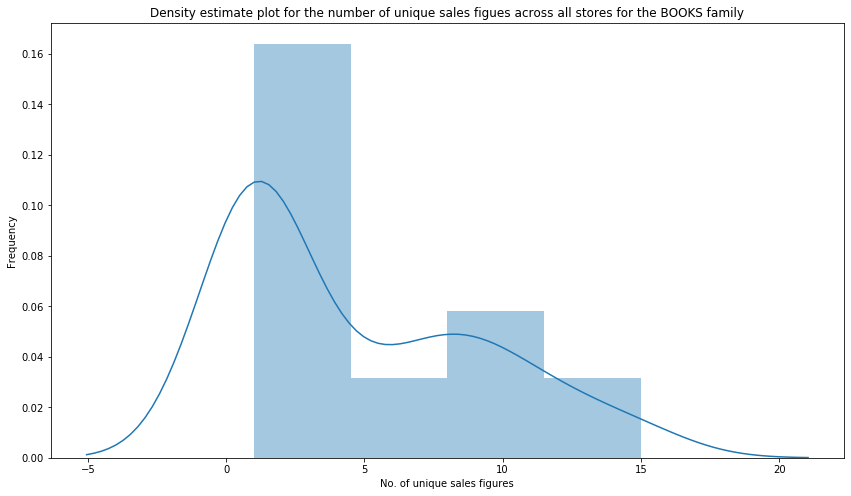

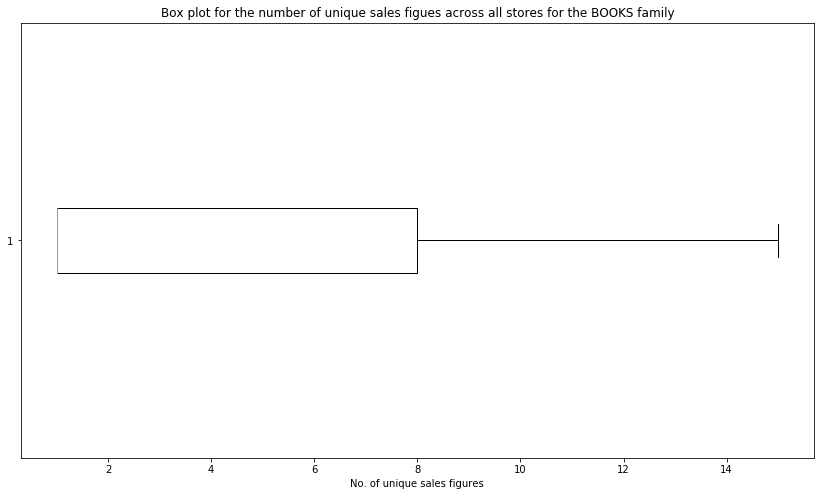

,summary_stats
count,54.000000
mean,4.685185
std,4.517572
min,1.000000
25%,1.000000
50%,1.000000
75%,8.000000
max,15.000000


In [12]:
# Code for creating visualisations for the number of
# unique sales figures for each store for given family


# Choose a product family
str_family = 'BOOKS'


# Count the number of unique sales figures from each time series
# and append results to a list
list_length = [
    len(
        set(
            short_sales_series(
                store_number = int_i, 
                family = str_family
            )
        )
    ) 
    for int_i in range(1,55)
]


# Produce a density plot of the data
plt.figure(
    num = 0, 
    figsize = (8 * (16 / 9) ,8)
)
plt.title(
    label = 'Density estimate plot for the number of unique sales figues across all stores for the ' + 
    str_family + 
    ' family'
)
plt.xlabel(
    xlabel = 'No. of unique sales figures'
)
plt.ylabel(
    ylabel = 'Frequency'
)
sns.distplot(
    a = list_length
)
plt.show()


# Produce a box plot of the data
plt.figure(
    num = 0, 
    figsize = (8 * (16 / 9) ,8)
)
plt.title(
    label = 'Box plot for the number of unique sales figues across all stores for the ' + 
    str_family + 
    ' family'
)
plt.xlabel(
    xlabel = 'No. of unique sales figures'
)
plt.boxplot(
    x = list_length,
    vert = False
)
plt.show()


# Output the summary statistics
pd.DataFrame(
    data = {
        'summary_stats': pd.Series(
            data = list_length
        )
    }
).describe()

The code below simply counts the total number of unique sales figures for a given product family across all stores.

In [13]:
# Code for counting all unique sales figues for given family across all stores

str_family = 'BOOKS'


set_data = set()

for int_i in range(1,55):
    set_data = set_data.union(
        set(
            short_sales_series(
                store_number = int_i, 
                family = str_family,
            )
        )
    )

# Output the count
print(
    len(
        set_data
    )
)

19


### Sales/Aggregate Correlation

The hypothesis behind the following EDA is whether all sales time series for a given product family are similar enough to be treated identically.

A simple 'measure' for the similarity between two time series is the linear correlation coefficient between the values of both series.

Letting $a_i$ be the $i$ th value in the first time series and $b_i$ be the $i$ th value in the second series, plot the coordinates $(a_i, b_i)$ for all $i$. If a linear relationship is clearly visible, then both time series are approximately similar.

Two time series are completely similar if they are both affine tranformations of each other (i.e. it is possible to express time series $a_i$ in terms of $b_i$ as $A + B a_i$, where $A$ and $B$ are real values).

It is costly to compare a large number of time series with each other to produce a correlation matrix, especially when the time series contain more than 1.5 thousand values. A less reliable, but quicker solution is to compare each time series with the sum of all time series (the aggregate time series).

The aggregate time series would be approximately similar to every series that forms the largest similarity group. This way, one can detect the existence of series groupings with a given set of series.

This EDA showed that the degree of similarity between series from the same product family can vary drastically, thereby giving convincing evidence that the time series can't be trivally grouped by the product family they represent.

/usr/lib/python3/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


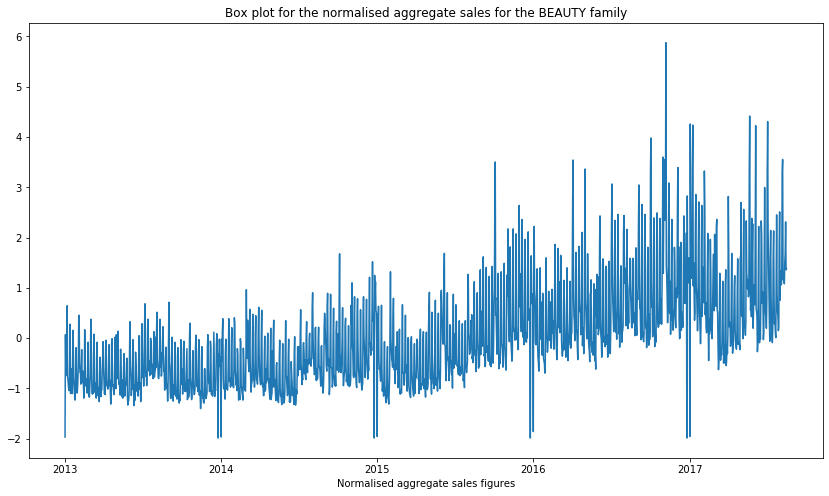

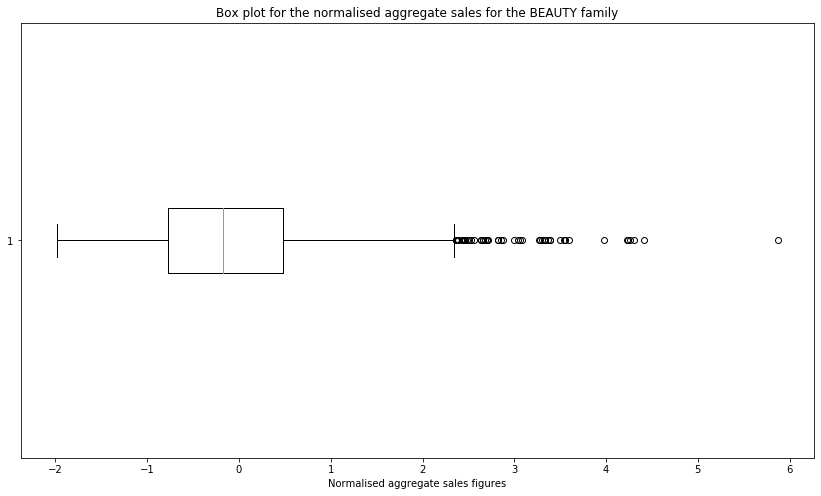

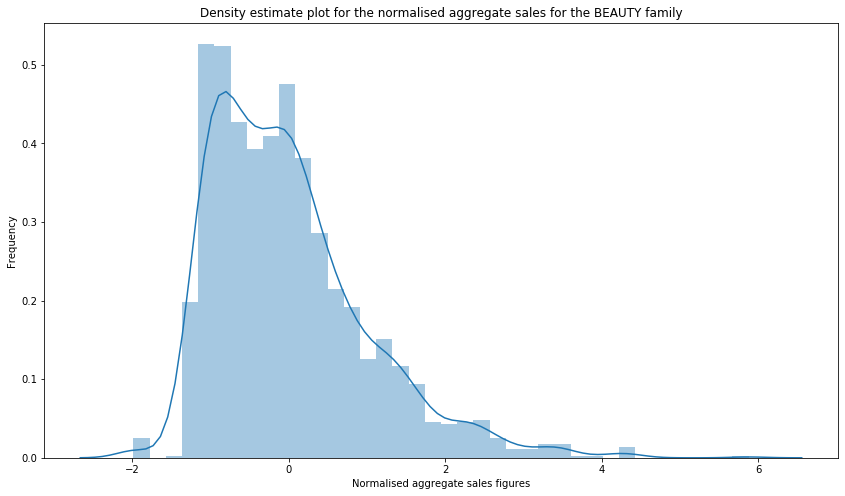

[0.18350644337809055, 0.5330622566463405, 0.8034949496629343, 0.6053872826620768, 0.5077146178973576, 0.7359616004641082, 0.39611606312612846, 0.7321610827411249, 0.6955900219678929, 0.25216812527893184, 0.6506542577879221, 0.14641330956355672, 0.33528559591369145, -0.025222364607820565, 0.19084745778811815, 0.17332435433335616, 0.4791741058542452, 0.44068629794093594, 0.43845883990088735, 0.7365368302854126, 0.6809431142156523, 0.5205855498528243, 0.4401606749709187, 0.5426425353567644, 0.34029776112176985, 0.3322017106066511, 0.5273153264327678, 0.48754191058122476, 0.6703262568129835, 0.23745006074192856, 0.5484206913928501, 0.20917646416580193, 0.35068836839906553, 0.41064999366422683, 0.20951409494548656, 0.43022615786480767, 0.4754727247812586, 0.7072236825263293, 0.5868644112870004, 0.3068766446222216, 0.6673476854919169, 0.7350122119790592, 0.3474933535035396, 0.7695030104269326, 0.781875648204868, 0.8338670781843751, 0.8347013942244532, 0.848286511491639, 0.753325880601954, 0.

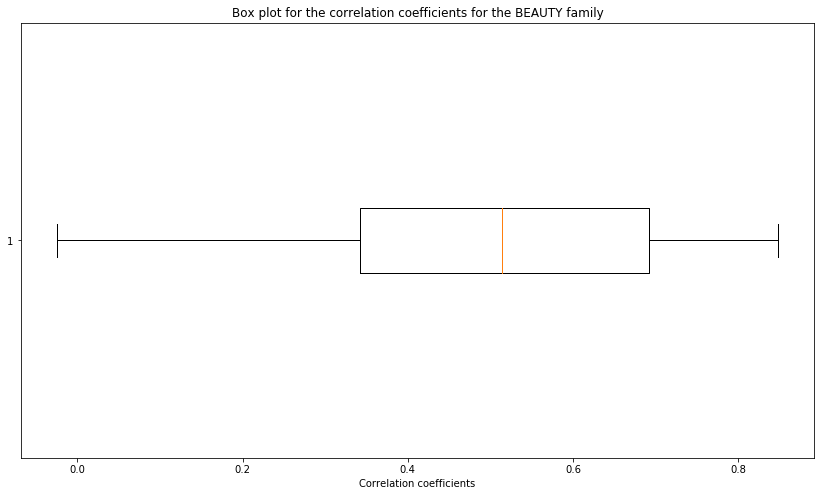

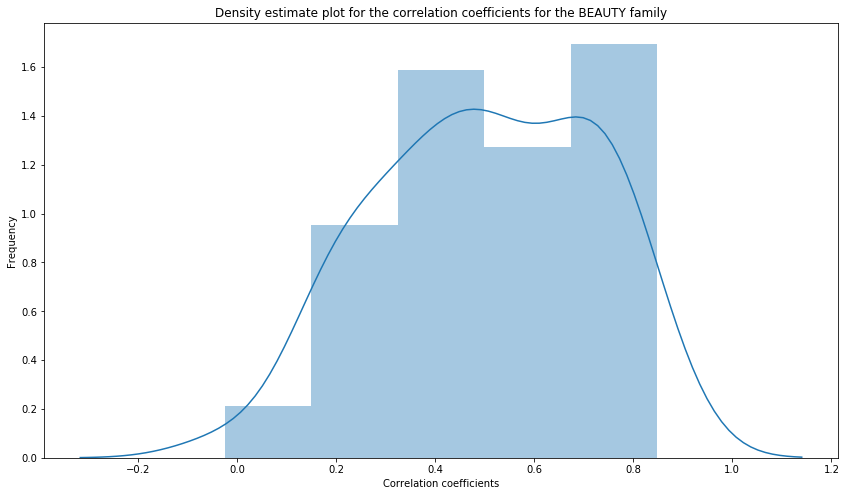

         summary
count  54.000000
mean    0.502024
std     0.218029
min    -0.025222
25%     0.341487
50%     0.514150
75%     0.691928
max     0.848287


In [14]:
str_family = 'BEAUTY'


# Create 'series_sum', the series on to which
# all sales will be added to
series_sum = pd.Series(
    data = np.zeros(
        shape = 1688,
    )
)


# Sum all the sales series for a given family
for int_i in range(1, 55):

    series_sum += short_sales_series(
        store_number = int_i, 
        family = str_family
    )


# Normalise 'series_sum'
series_sum_norm = (series_sum - np.mean(series_sum)) / (np.std(series_sum))


# Visualise time series of 'series_sum_norm'
plt.figure(
    num = 0, 
    figsize = (8 * (16 / 9) ,8)
)

plt.title(
    label = 'Box plot for the normalised aggregate sales for the ' + 
    str_family + 
    ' family'
)

plt.xlabel(
    xlabel = 'Normalised aggregate sales figures'
)

plt.plot(
    pd.Series(
        data = pd.date_range(
            start = datetime.datetime(
                year = 2013, 
                month = 1, 
                day = 1
            ),
            end = datetime.datetime(
                year = 2017, 
                month = 8, 
                day = 15
            )
        )
    ),
    series_sum_norm
)

plt.show()


# Create a visualisation of 'series_sum_norm'
plt.figure(
    num = 0, 
    figsize = (8 * (16 / 9) ,8)
)

plt.title(
    label = 'Box plot for the normalised aggregate sales for the ' + 
    str_family + 
    ' family'
)

plt.xlabel(
    xlabel = 'Normalised aggregate sales figures'
)

plt.boxplot(
    x = series_sum_norm,
    vert = False
)

plt.show()



# Produce a density plot of the data
plt.figure(
    num = 0, 
    figsize = (8 * (16 / 9) ,8)
)

plt.title(
    label = 'Density estimate plot for the normalised aggregate sales for the ' + 
    str_family + 
    ' family'
)

plt.xlabel(
    xlabel = 'Normalised aggregate sales figures'
)

plt.ylabel(
    ylabel = 'Frequency'
)

sns.distplot(
    a = series_sum_norm
)

plt.show()




# Create list for storing correlation coefficients
list_correlation = list()


# Append correlation coefficients to 'list_correlation'
for int_i in range(1, 55):

    list_correlation.append(
        scipy.stats.pearsonr(
            x = series_sum_norm,
            y = short_sales_series(
                store_number = int_i, 
                family = str_family
            )
        )[0]
    )



# Filter out any missing values arising from
# invalid correlation calculations
list_correlation_mod = [
    float_x for 
    float_x in 
    list_correlation if 
    np.isnan(float_x) == False
]

print(
    list_correlation_mod
)


# Visualise the distribution of 'list_correlation'
plt.figure(
    num = 0, 
    figsize = (8 * (16 / 9) ,8)
)


plt.title(
    label = 'Box plot for the correlation coefficients for the ' + 
    str_family + 
    ' family'
)

plt.xlabel(
    xlabel = 'Correlation coefficients'
)

plt.boxplot(
    x = list_correlation_mod,
    vert = False
)

plt.show()




plt.figure(
    num = 0, 
    figsize = (8 * (16 / 9) ,8)
)

plt.title(
    label = 'Density estimate plot for the correlation coefficients for the ' + 
    str_family + 
    ' family'
)

plt.xlabel(
    xlabel = 'Correlation coefficients'
)

plt.ylabel(
    ylabel = 'Frequency'
)

sns.distplot(
    a = list_correlation_mod
)

plt.show()


print(
    pd.DataFrame(
        data = np.array(
            list_correlation_mod
        ),
        columns = ['summary']
    ).describe()
)

### Transaction Levels

This EDA was an attept to see if the transaction data can be used to classify different stores. By deriving the overall volume of transactions taking place for each store, we could indicate which stores are smaller (less transactions) and which are larger (more transactions).

The transaction levels for a store was is defined as the average of the mean and median transaction (reasonable only when the mean and median are close). Upon creating a list of transaction levels for each store, we found no clear distinction between the levels. 

We were unable to derive an efficient enough grouping from the EDA, meaning we had to rely on more arbitrary classification techniques such as K-means clustering.

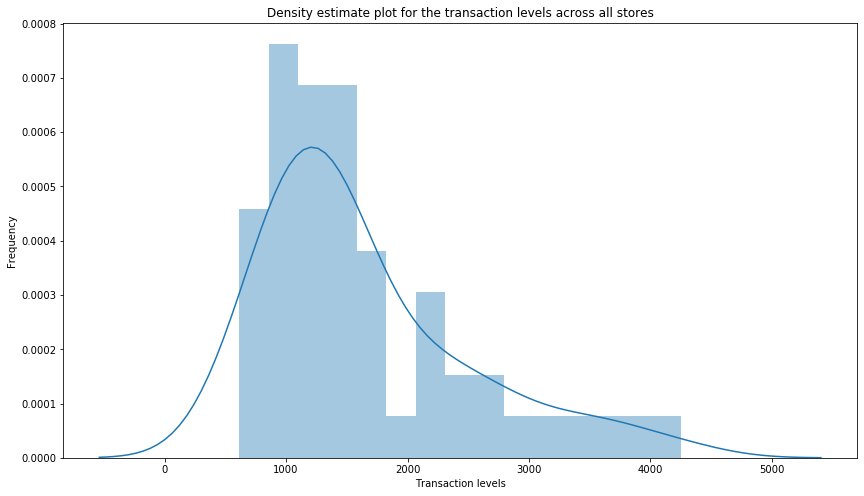

In [15]:
# Code for creating dataset of transaction levels for each store number


series_trans_level = pd.Series()


for int_i in range(1, 55):

    dataframe_trans_specific = dataframe_transactions[
        dataframe_transactions[
            'store_nbr'
        ] == int_i
    ]


    dataframe_trans_summary = pd.DataFrame(
        data = np.array(
            dataframe_trans_specific[
                'transactions'
            ]
        )
    ).describe()[0]


    series_trans_level = series_trans_level.append(
        pd.Series(
            data = (dataframe_trans_summary['50%'] + dataframe_trans_summary['mean']) / 2
        ),
        ignore_index = True
    )


plt.figure(
    num = 0, 
    figsize = (8 * (16 / 9) ,8)
)

plt.title(
    label = 'Density estimate plot for the transaction levels across all stores'
)

plt.xlabel(
    xlabel = 'Transaction levels'
)

plt.ylabel(
    ylabel = 'Frequency'
)

sns.distplot(
    a = series_trans_level,
    bins = 15
)

plt.show()

## LSTM (Long-Short Term Memory)

This section discusses the use of an LSTM machine learning technique for predicting time series and what aspects of the model make it suitable compared with others.

### LSTM Theory

LSTM is a recurrent neural network (RNN) that utilises two different hidden variables rather than one to learn about the behaviour of a sequential process. While an simple RNN uses its hidden variable as a short term memory channel, LSTM uses a second one for long term memory, which, theoretically, preserves significant patterns of the system's behaviour in the model for as long as they persist.

A standard LSTM can be formulated by the following four equations, given we already have data up until time $t-1$:

<center>

$f_t = \sigma (W_f \cdot [h_{t-1}, x_t] + b_f)$

$i_t = \sigma (W_i \cdot [h_{t-1}, x_t] + b_i)$

$\bar{C}_t = \text{tanh} (W_C \cdot [h_{t-1}, x_t] + b_C)$

$C_t = f_t \times C_{t-1} + i_t \times \bar{C}_t$

$o_t = \sigma (W_o \cdot [h_{t-1}, x_t] + b_o)$

$h_t = o_t \times \text{tanh}(C_t)$
    
</center>

The first equation represents the forget gate, the perceptron layer responsible for removing any insignificant patterns the long term memory assumed from the last iteration.

The second equation represents the information gate, the layer accountable for recording new potential patterns into the long term memory and strengthen ones that were present before.

The third equation offers a candidate long term memory term, which is corrected by the information gate, as visible in the fourth equation.

The fifth equation is the output gate, the layer for creating the final output that will be used for creating the next short term hidden variable, as shown in the sixth equation.

The $\times$ symbol represents termwise multiplication.

Each term at time $t$ is defined as follows:
- $x_t$ is the data
- $h_t$ is the hidden short term memory variable
- $C_t$ is the hidden long term memory variable
- $\bar{C}_t$ is a candidate for $C_t$
- $f_t$ is the forget vector
- $i_t$ is the information vector
- $o_i$ is the output vector

- All $W$ matricies are the weights that dictate how much of each term in the input contributes to the value of the output
- All $b$ vectors are biases that set the default values of the variables they form

- $\sigma$ is the element-wise sigmoid activator function
- $\text{tanh}$ is the element_wise hyperbolic tangent activator function

LSTM allows for modelling arbitrary patterns in time series or any sequential process becuase of its neural-like nature.

### Predictions

Here we discuss making the predictions with LSTMs.

Firstly, we load the necessary data series:


In [54]:
# Prerequisites:
# - 'dataframe_subject_f' // dataframe

series_date = dataframe_subject_f['date']
series_sales = dataframe_subject_f['sales']
series_oil = dataframe_subject_f['dcoilwtico']
series_promo = dataframe_subject_f['onpromotion']

Here, we prepare the sales data for training the model and predicting the 16 day we need.

The preparation process involves transforming the data so it ranges from zero to one, as LSTMs perceptrons main use sigmoid activator functions that also only output values from zero to one.

In [55]:
# Create 'series_scaled_sales' and 'minmaxscaler_scale_sales',
# a rescaled version of 'series_sales' and the scaler
# respectively
series_scaled_sales, minmaxscaler_scale_sales = custompack.zero_one_scaler(
    series_main = dataframe_subject_f['sales']
)

# Shorten 'series_scaled_sales' by 16 days, since
# we want to predict the last 16 days out of the 
# 1704 that there are
series_scaled_short_sales = custompack.series_extender(
    series_main = series_scaled_sales,
    int_extension = -16
)

# Convert 'series_scaled_short_sales' into a matrix
# array with one column
matrix_scaled_train = np.array(series_scaled_short_sales).reshape(-1,1)

# Set the number of days to train from
int_prediction_days = 50

# Create lists for training
list_x_train = []
list_y_train = []

# Set the number of observations there are
# in 'matrix_scaled_train'
int_train_data = np.shape(matrix_scaled_train)[0]

# Create for loop for appending data
# to training lists
for int_i in range(
    int_prediction_days,
    int_train_data
):

    # Append a cut version of 'matrix_scaled_train'
    # to 'list_x_train'
    list_x_train.append(
        matrix_scaled_train[int_i - int_prediction_days: int_i]
    )

# Convert 'list_x_train' into a lattice array
lattice_x_train = np.array(list_x_train)


for int_i in range(
    int_prediction_days,
    int_train_data
):

    list_y_train.append(
        matrix_scaled_train[int_i, 0]
    )

vector_y_train = np.array(list_y_train)


Below, we define the LSTM model with 50 units (output is a hidden variable of length 50) with a rectified linear unit activator function with a combining dense perceptron layer in the end to create a single prediction.

The model is concluded with an Adam optimiser and a mean square loss function.

In [56]:
# Define the sequential model 'sequential_model'
sequential_model = keras.models.Sequential()

# Add an LSTM module to 'sequential_model'
# with 50 units and a rectified linear
# unit activation function
sequential_model.add(
    keras.layers.LSTM(
        units = 50,
        activation = 'relu', 
        input_shape = ( 
            lattice_x_train.shape[1],
            lattice_x_train.shape[2]
        )
    )   
)

# Add a final dense layer to
# 'sequential_model'
sequential_model.add(
    keras.layers.Dense(1)
)

# Compile 'sequential_model' with
# an optimiser and a loss function
sequential_model.compile(
    optimizer = 'adam', 
    loss = 'mse' 
)

Here, the model is trained for one epoch (one training cycle) so model is fitted to the sales series only once

In [57]:
# Train the model
sequential_model.fit(
    x = lattice_x_train, 
    y = vector_y_train, 
    epochs = 1, 
    verbose = 1
    )

Epoch 1/1
1638/1638 [==============================] - 2s 1ms/step - loss: 0.0208


Finally, prepare the predictions using the trained model and convert them into a series to graph them.

In [58]:
# This for loop is responsible for generating
# and appending predictions to 'matrix_scaled_train'
for int_i in range(int_train_data, int_train_data + 16):

    # Extract the terms from 'matrix_scaled_train'
    # used for making the next prediction
    matrix_terms = matrix_scaled_train[int_i - int_prediction_days: int_i]

    # Create the prediction
    matrix_prediction = sequential_model.predict(
        x = np.array([matrix_terms]), 
        verbose = 0
    )

    # Append the prediction to 'matrix_scaled_train'
    matrix_scaled_train = np.concatenate(
        (
            matrix_scaled_train,
            matrix_prediction
        )
    )


In [59]:
# Rescale 'matrix_scaled_train' back to
# 'matrix_train' using the previously created
# 'minmaxscaler_scale_sales'
matrix_train = minmaxscaler_scale_sales.inverse_transform(
    matrix_scaled_train
)

# Convert 'matrix_train' into a series called
# 'series_predictions'
series_predictions = pd.Series(
    data = matrix_train.reshape(-1)
)

Below is a graph of the predictions (orange) for the next 16 days, which are the days for which 'series_sales' (blue) is zero. This is for the sales for store number 20 and product family 'EGGS'.

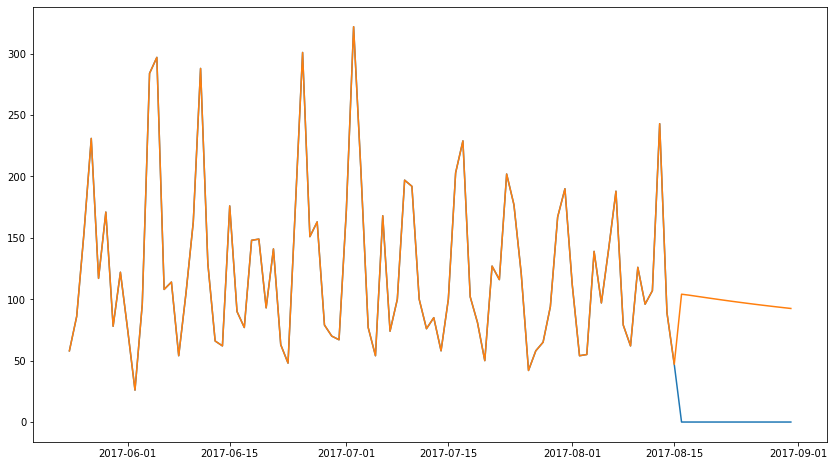

In [60]:
series_date = dataframe_subject_f['date']
series_sales = dataframe_subject_f['sales']

int_date_length = len(series_date)

int_farback = 0
int_inter = 100

int_start = int_date_length - int_inter - int_farback
int_end = int_date_length - int_farback

plt.figure(
    num = 0,
    figsize = (8 * (16 / 9), 8)
)
plt.plot(
    series_date.iloc[int_start: int_end],
    series_sales.iloc[int_start: int_end],
)
plt.plot(
    series_date.iloc[int_start: int_end],
    series_predictions.iloc[int_start: int_end],
)
plt.show()

## Dynamic Linear Models

This section discusses the use of a dynamic linear model for predicting time series and what aspects of the model make it suitable compared with others.

### DLM Theory

State space models are a generalisation of general linear regression models. Unlike GLMs, which include ARIMA models, SSMs can consider cases where the underlying distribution of the parameters of the model changes over time. A dynamic linear model is an SSM that assumes the data can be modelled as a linear combination of its parameters.

A standard DLM can be formulated by the following four equations, given we already have data up until time $t-1$:

<center>

$x_t = \phi_t \cdot b_t + \epsilon_t : \epsilon_t \sim N(0, v_t)$

$b_t = F_t \cdot b_{t-1} + \Delta_t : \Delta_t \sim N(0, v_{t-1} \Sigma_t)$

$b_{t-1} = m_{t-1} + \Beta_{t-1} : \Beta_{t-1} \sim N(0, v_{t-1} B_{t-1})$

$v_t = \delta v_{t-1}$
    
</center>

The first equation is an ordinary linearity assumption for the data, the same one for ordinary linear regression, except the parameters can vary over time.

The second equation is the hidden model and is the key assumption for a linear model to be dynamic.

The third equation is a reiteration of the fact that the model parameters are random as well. The parameters possess an initial prior distribution which updates as more data is collected.

The fourth equation models the change in variance as time progresses.

Each term at time $t$ is defined as follows:
- $x_t$ is the data
- $b_t$ is the parameter vector
- $\epsilon_t$ is a normally distributed variable with variance $v_t$

- $m_t$ is the expectation of the parameters
- Both $\Beta_t$ and $\Delta_t$ are multivariate normally distributed vectors with covariance matricies $v_t B_t$ and $v_{t-1} \Sigma_t$ respectively

- $\phi_t$ and $F_t$ are the transition vector and matrix respectively, which define how the model parameters combine linearly
- $\delta$ is the discount factor, a value in the interval of zero to one that models the increasing uncertainty in the distribution of future data

The model reduces to ordinary linear regression if:
- $F_t$ is the identity matrix for all $t$
- $\Sigma_t$ is the zero matrix for all $t$
- $\delta$ is one, so there is no increasing uncertainty in the distribution of future data

The dynamic linear model offers a high degree of modelling flexibility, as well as offering a convenient method for updating the model parameters over time.

### Functions

Below, we cover the important functions for producing a dynamic linear model and how how to use them for forecasting.

The 'bayesian_update' function is at the heart of our DLM model, as it is responsible for optimally updating the model parameters on the basis of Bayesian statistics.

The bayesian updates that take place are summarised as follows:

- Pre posterior weight matrix: $P = F \cdot B_{t-1} \cdot F^{T} + \Sigma$
- Variance multiplier: $q = \delta + \phi_t \cdot P \cdot \phi_t$
- The gain vector: $g = (P \cdot \phi_t)/q$
- The residual estimate: $e = x_t - \phi_t \cdot F \cdot m_{t-1}$

The most important ones being:

- The posterior mean vector: $m_t = F \cdot m_{t-1} + ge$
- The posterior weight matrix: $B_{t} = P/\delta - (g \circ g)q$

Where $\circ$ denotes the outer product.

The 'filter_arma' function uses the majority of functions from 'custompack', including 'bayesian_update' to fit a DLM and predict a chosen amount of terms for a given series.

### Predictions

Here we discuss making the predictions with DLMs.

Firstly, we load the necessary data series:


In [61]:
# Prerequisites:
# - 'dataframe_subject_f' // dataframe

series_date = dataframe_subject_f['date']
series_sales = dataframe_subject_f['sales']
series_oil = dataframe_subject_f['dcoilwtico']
series_promo = dataframe_subject_f['onpromotion']

Here is where the hyper parameters are set and the model itself is trained.

After testing different hyperparameter combinations and using both the oil prices and promotion time series to predict the sales, the best choice turned out to be the simplest model. 

Below, we incorporate the local level model with an AR(50) model that only considers the original time series. Using other time series for producing predictions actually causes a weaker model fit.

In [62]:
int_series_cut = 16
int_series_pred = 16

# Set 'series_nds', the series containing
# all one-step forecasts and the predictions
# for the sales generated by the DLM defined
# below
series_nds = custompack.filter_arma(
    series_x = series_sales,
    tuple_hyperpar = (
        np.array([series_sales[0]]),
        np.array([[0.5]]),
        np.array([[1]]),
        np.array([[0.9]]),
    ),
    vector_phi = np.array([1]),
    series_y = pd.Series([]),
    series_z = pd.Series([]),
    float_delta = 1,
    int_ar_terms = 50,
    int_series_cut = int_series_cut,
    int_series_pred = int_series_pred,
)

In [63]:
# Create full series of dates from
# 2013-01-01 to 2017-08-31

# Prerequisites:
# - None

# Create 'datetime_start_date' as the starting date
datetime_start_date = datetime.datetime(
    year = 2013,
    month = 1,
    day = 1,
)

# Create 'datetime_end_date' as the final date
datetime_end_date = datetime.datetime(
    year = 2017,
    month = 8,
    day = 31,
)

timedelta_day = datetime.timedelta(
    days = 1,
)

datetime_real_end_date = datetime_end_date + (int_series_pred - int_series_cut) * timedelta_day

# Create 'datetimeindex_fulldate', the list of all
# dates from the initial to the final date
datetimeindex_fulldate = pd.date_range(
    start = datetime_start_date,
    end = datetime_real_end_date,
)

# Convert 'datetimeindex_fulldate' into a pandas
# series
series_fulldate = pd.Series(
    data = datetimeindex_fulldate,
)

Below is an example plot for the predictions (orange) made by the model for the sales (blue) for store number 20 and product family 'EGGS'.

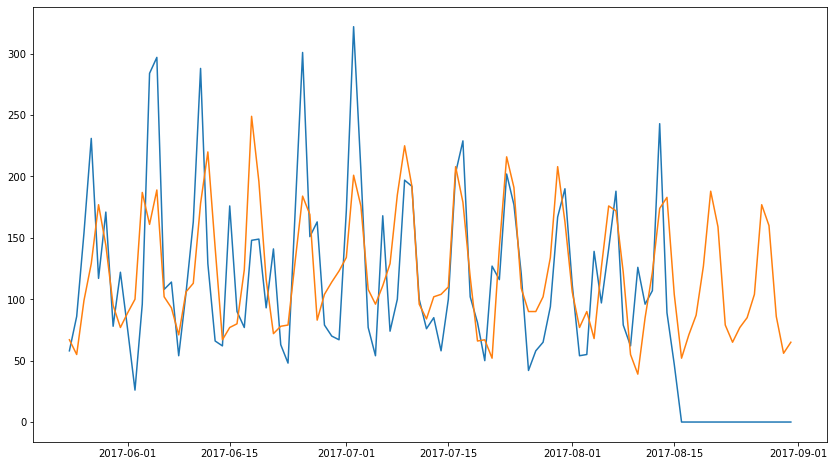

In [64]:
int_date_length = len(series_fulldate)

int_farback = 0
int_inter = 100

int_start = int_date_length - int_inter - int_farback
int_end = int_date_length - int_farback

series_extended_sales = custompack.series_extender(
    series_main = series_sales,
    int_extension = int_series_pred - int_series_cut,
)

plt.figure(
    num = 0,
    figsize = (8 * (16 / 9), 8)
)
plt.plot(
    series_date.iloc[int_start: int_end],
    series_sales.iloc[int_start: int_end],
)
plt.plot(
    series_date.iloc[int_start: int_end],
    series_nds.iloc[int_start: int_end],
)
plt.show()

## Evaluation

LSTM was extremely difficult to get working. Even when it finally did, it couldn't recreate the success that ARIMA and DLM models offer in terms of time series prediction.

LSTMs take longer to learn and are finicky to set up properly compared with the straightforward and intuitive nature of DLMs.

DLMs, however, are restricted by their linear nature and could miss deeper underlying patterns in series which neural networks are celebrated for detecting.

It may still be worth revisiting LSTM in the future, but already having more experince and knowledge of how to use it properly.